# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to __build and evaluate a predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use __a simple model such as Logistic Regression__ for this task or try one of the __more advanced methods__ covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out __which features provide the most accurate results.__  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.feature_selection import RFE

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn=churn.dropna(axis=1)
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND
INDEX,,,,,,,,,,,,,,,
1,1,46,1,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40
2,2,60,3,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54
3,5,65,1,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50
4,6,31,1,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48
5,8,95,1,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22


In [3]:
churn.shape

(46206, 15)

In [4]:
churn.CHURN_IND.value_counts()

0    28416
1    17790
Name: CHURN_IND, dtype: int64

### My idea 
- use logistic regression
    - collect useful(subjective) numerical variables.
        e.g.CUST_ID is useless
      
    - collect useful categorical variables, convert them into numerical ones by One-hot encoding.
        e.g.HANDSET_USED_BRAND
        
        Note:I tried to count the HANDSET_USED_BRAND in, the model acuuracy doesn't change much and it complex the model.
        when I counted HANDSET_USED_BRAND in, model choose all of (HANDSET_USED_BRAND_APPLE', 'HANDSET_USED_BRAND_HUAWEI',
       'HANDSET_USED_BRAND_OTHER', 'HANDSET_USED_BRAND_SAMSUNG','HANDSET_USED_BRAND_UNKNOWN') as factor, which doesn't give usuful infomation, So I decided to exclude HANDSET_USED_BRAND factor.
       
- use REF to reduce relative variables
- test the accuracy of the model.

In [5]:
categorical=churn[['CFU','BYO_PLAN_STATUS','CONTRACT_STATUS']]
categorical.head()

,CFU,BYO_PLAN_STATUS,CONTRACT_STATUS
INDEX,,,
1,CONSUMER,NON BYO,OFF-CONTRACT
2,CONSUMER,NON BYO,OFF-CONTRACT
3,CONSUMER,BYO,OFF-CONTRACT
4,CONSUMER,NON BYO,OFF-CONTRACT
5,CONSUMER,NON BYO,OFF-CONTRACT


In [6]:
Dummy=pd.get_dummies(categorical)
Dummy.head()

,CFU_CONSUMER,CFU_SMALL BUSINESS,BYO_PLAN_STATUS_BYO,BYO_PLAN_STATUS_NON BYO,CONTRACT_STATUS_NO-CONTRACT,CONTRACT_STATUS_OFF-CONTRACT,CONTRACT_STATUS_ON-CONTRACT
INDEX,,,,,,,
1,1,0,0,1,0,1,0
2,1,0,0,1,0,1,0
3,1,0,1,0,0,1,0
4,1,0,0,1,0,1,0
5,1,0,0,1,0,1,0


In [7]:
new_churn=pd.concat([churn,Dummy],axis=1)
new_churn=new_churn.drop(['CUST_ID','HANDSET_USED_BRAND','CFU','BYO_PLAN_STATUS','CONTRACT_STATUS'],axis=1)
new_churn.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,CFU_CONSUMER,CFU_SMALL BUSINESS,BYO_PLAN_STATUS_BYO,BYO_PLAN_STATUS_NON BYO,CONTRACT_STATUS_NO-CONTRACT,CONTRACT_STATUS_OFF-CONTRACT,CONTRACT_STATUS_ON-CONTRACT
INDEX,,,,,,,,,,,,,,,,,
1,46,1,46,54.54,15,0,24,24,1,61.40,1,0,0,1,0,1,0
2,60,3,59,54.54,5,0,24,24,1,54.54,1,0,0,1,0,1,0
3,65,1,65,40.90,15,0,12,12,1,2.50,1,0,1,0,0,1,0
4,31,1,31,31.81,31,0,24,24,1,6.48,1,0,0,1,0,1,0
5,95,1,95,54.54,0,0,24,24,1,100.22,1,0,0,1,0,1,0


## split data into train and test

In [8]:
feature_cols=np.array(['ACCOUNT_TENURE','ACCT_CNT_SERVICES','SERVICE_TENURE','PLAN_ACCESS_FEE','PLAN_TENURE','MONTHS_OF_CONTRACT_REMAINING','LAST_FX_CONTRACT_DURATION','PREV_CONTRACT_DURATION','MONTHLY_SPEND','CFU_CONSUMER','CFU_SMALL BUSINESS','BYO_PLAN_STATUS_BYO','BYO_PLAN_STATUS_NON BYO','CONTRACT_STATUS_NO-CONTRACT','CONTRACT_STATUS_OFF-CONTRACT','CONTRACT_STATUS_ON-CONTRACT'])

X=new_churn[feature_cols]
y=new_churn['CHURN_IND']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=142)

In [9]:
lg=LogisticRegression(C=1e9)
lg.fit(X_train,y_train)

C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1000000000.0)

In [10]:
# Evaluate the performance of your trained model

train_preds = lg.predict(X_train)
test_preds = lg.predict(X_test)
print('Train accuracy')
print(accuracy_score(y_train,train_preds))
print('Test accuracy')
print(accuracy_score(y_test,test_preds))

Train accuracy
0.7178335677956931
Test accuracy
0.7166197792685566


In [16]:
# confusion matrix
print('Train confusion matrix')
print(confusion_matrix(y_train,train_preds))

print('Test confusion matrix')
print(confusion_matrix(y_test,test_preds))

Train confusion matrix
[[18871  3820]
 [ 6585  7688]]
Test confusion matrix
[[4734  991]
 [1623 1894]]


### RFE

In [11]:
X_train.shape

(36964, 16)

In [12]:
train_acc=[]
test_acc=[]

for i in range(X_train.shape[1]):
    lg=LogisticRegression()
    rfe=RFE(estimator=lg,n_features_to_select=i+1,step=1)
    rfe.fit(X_train,y_train)
    
    train_preds=rfe.predict(X_train)
    test_preds=rfe.predict(X_test)
    train_acc.append(accuracy_score(y_train,train_preds))
    test_acc.append(accuracy_score(y_test,test_preds))

C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Text(0, 0.5, 'accuracy')

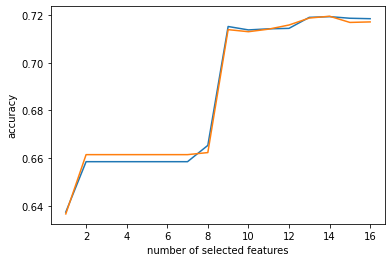

In [13]:
plt.plot(range(1, X_train.shape[1]+1), train_acc)
# X_train.shape[1] means the 16 features we have, +1 for range() method inclusive the second parameter.
plt.plot(range(1, X_train.shape[1]+1),test_acc)
# for X_train and X_test have same number of columns, we keep use X_train.shape[1]

plt.xlabel('number of selected features')
plt.ylabel('accuracy')

**From the plot, I think around 10 features can explain Mobile Customer Churn well.**  

In [14]:
lg = LogisticRegression()
rfe = RFE(estimator = lg, n_features_to_select=10, step=1)

rfe.fit(X_train,y_train)

C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Melinda\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

RFE(estimator=LogisticRegression(), n_features_to_select=10)

In [15]:
#show the 10 choosen features
X_train.columns[rfe.support_]

Index(['ACCOUNT_TENURE', 'MONTHS_OF_CONTRACT_REMAINING',
       'PREV_CONTRACT_DURATION', 'MONTHLY_SPEND', 'CFU_CONSUMER',
       'CFU_SMALL BUSINESS', 'BYO_PLAN_STATUS_BYO', 'BYO_PLAN_STATUS_NON BYO',
       'CONTRACT_STATUS_OFF-CONTRACT', 'CONTRACT_STATUS_ON-CONTRACT'],
      dtype='object')

## Conclusion 

- The train accuracy of model is 0.7178 and the test accuracy is 0.7166. The model is not overfitting. But the overall accuracy needs to be imporved by seeking for other usufel infomation.

Form the modle I built, those are the main factors that will affect Mobile Customer Churn:
- ACCOUNT_TENURE
- MONTHS_OF_CONTRACT_REMAINING
- PREV_CONTRACT_DURATION
- MONTHLY_SPEND
- CFU STATUS
- BYO_PLAN_STATUS
- CONTRACT_STATUS